In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
shops = pd.read_csv('../data/interim/shops_appearence.csv', parse_dates=['shop_appearence'])
items = pd.read_csv('../data/interim/items_appearence.csv', parse_dates=['item_appearence'])
item_cat = pd.read_csv('../data/interim/item_categories_global.csv')

sales = pd.read_csv('../data/interim/sales_train_etl.csv', parse_dates=['date'])

datasets = {'shops': shops, 'items': items, 'item_categories': item_cat}

In [5]:
train_data = pd.read_csv('../data/interim/train_2013-6_to_2015-6.csv', parse_dates=['date'])
val_data = pd.read_csv('../data/interim/val_2015-7.csv', parse_dates=['date'])

In [6]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-06-16,5,30,11496,399.00,1.0
1,2013-06-14,5,30,11244,149.00,1.0
2,2013-06-06,5,30,11388,898.85,2.0
3,2013-06-15,5,30,11249,399.00,1.0
4,2013-06-13,5,30,8081,299.00,1.0


# New features

* how many unique items are sold currently in the shop
* how many shops sell this particular item
* what was item's median price last month
* how many items (in general) were sold in shop last month

In [7]:
unique_items_in_shop = pd.read_csv('../data/interim/unique_items_in_shop.csv')
unique_shops_sell_item = pd.read_csv('../data/interim/unique_shops_sell_item.csv')
price_pivot = pd.read_csv('../data/interim/price_pivot.csv')
total_sales_pivot = pd.read_csv('../data/interim/shop_total_sales_pivot.csv')
monthly_sales_pivot = pd.read_csv('../data/interim/sales_pivot.csv')

#### Code for generating new features, in case they need to be recalculated

In [186]:
unique_items_in_shop = sales.groupby(['shop_id', 'date_block_num']).agg({'item_id':'nunique'}).reset_index()
unique_items_in_shop.rename(columns={'item_id': 'items_selling'}, inplace=True)
unique_items_in_shop_pivot = pd.pivot_table(unique_items_in_shop, values='items_selling', index=['shop_id'],columns=['date_block_num']).fillna(0).reset_index()
unique_items_in_shop_pivot.to_csv('../data/interim/unique_items_in_shop.csv', index=False)

In [187]:
unique_shops_sell_item = sales.groupby(['item_id', 'date_block_num']).agg({'shop_id':'nunique'}).reset_index()
unique_shops_sell_item.rename(columns={'shop_id': 'sold_in_shops'}, inplace=True)
unique_shops_sell_item_pivot = pd.pivot_table(unique_shops_sell_item, values='sold_in_shops', index=['item_id'],columns=['date_block_num']).fillna(0).reset_index()
unique_shops_sell_item_pivot.to_csv('../data/interim/unique_shops_sell_item.csv', index=False)

In [188]:
price_month = sales.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_price':'median'}).reset_index()
price_pivot = pd.pivot_table(price_month, values='item_price', index=['item_id', 'shop_id'],columns=['date_block_num']).fillna(0).reset_index()
price_pivot.to_csv('../data/interim/price_pivot.csv', index=False)

In [189]:
shop_sales_month = sales.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_day':'sum'}).reset_index().rename(columns={'item_cnt_day':'item_sold_month'})
shop_total_sales_pivot = pd.pivot_table(shop_sales_month, values='item_sold_month', index=['shop_id'],columns=['date_block_num']).fillna(0).reset_index()
shop_total_sales_pivot.to_csv('../data/interim/shop_total_sales_pivot.csv', index=False)

# Incorporating new features into feature extraction pipeline

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
import category_encoders as ce

## Simple features extraction pipeline

In [9]:
class MonthFromDate(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['month'] = X['date_block_num'] % 12 + 1
        X['month_sin'] = np.sin(2 * np.pi * X['month']/12.0)
        X['month_cos'] = np.cos(2 * np.pi * X['month']/12.0)
        X.drop(['month'], axis=1, inplace=True)
        return X
    
class ShopItemAge(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['shop_age_month'] = (X['date'] - X['shop_appearence']).dt.days / 30
        X['item_age_month'] = (X['date'] - X['item_appearence']).dt.days / 30
        X.drop(['shop_appearence','item_appearence','date'], axis=1, inplace=True) 
        
        return X
    
class MonthlySales(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.groupby(['date_block_num','item_id', 'shop_id']).agg({'item_cnt_day':'sum',
                                                                    'date':'max',
                                                                   }).reset_index().rename({'item_cnt_day':'item_cnt_month'}, axis=1)

        return X

class MergeTables(BaseEstimator, TransformerMixin):
    def __init__(self, lookup_tables):
        self.items = lookup_tables['items']
        self.shops = lookup_tables['shops']
        self.item_cat = lookup_tables['item_categories']
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X = X.merge(self.items, on='item_id', how='left')
        X = X.merge(self.item_cat, on='item_category_id', how='left')
        X = X.merge(self.shops, on='shop_id', how='left')
        X['item_appearence'] = X['item_appearence'].fillna(X['date'])
        X['shop_appearence'] = X['shop_appearence'].fillna(X['date'])
        X = X.fillna(0)
        X.drop(['item_name', 'shop_name', 'item_category_name', 'city', 'global_cat'], axis=1, inplace=True)

        return X

extraction_steps = [("montly_sales", MonthlySales()),
                ("month_feat", MonthFromDate()),
                ("merge", MergeTables(datasets)),
                ("ages", ShopItemAge())
            ]
        
feature_extraction_pipeline = Pipeline(steps=extraction_steps)

## Lag features pipeline

In [10]:
class GetLagSales(BaseEstimator, TransformerMixin):
    def __init__(self, lags, df):
        self.lags = lags
        self.df = df
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].values[0]
        X = X.merge(self.df, on=['item_id', 'shop_id'], how='left')
        X = X.fillna(0)
        for lag in self.lags:
            if date_block - lag >= 0:
                X[f'item_sales_lag_{lag}'] = X.loc[:, str(int(date_block-lag))]
            else:
                X[f'item_sales_lag_{lag}'] = 0
        
        return X
    
class GetLagPrice(BaseEstimator, TransformerMixin):
    def __init__(self, lags, df):
        self.lags = lags
        self.df = df
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].values[0]
        X = X.merge(self.df, on=['item_id', 'shop_id'], how='left')
        X = X.fillna(0)
        for lag in self.lags:
            if date_block - lag >= 0:
                X[f'price_lag_{lag}'] = X.loc[:, str(int(date_block-lag))]
            else:
                X[f'price_lag_{lag}'] = 0
                                                     
        X.drop([str(i) for i in range(34)], axis=1, inplace=True)
        return X
    
class GetLagTotalSales(BaseEstimator, TransformerMixin):
    def __init__(self, lags, df):
        self.lags = lags
        self.df = df
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].values[0]
        X = X.merge(self.df, on=['shop_id'], how='left')
        X = X.fillna(0)
        for lag in self.lags:
            if date_block - lag >= 0:
                X[f'total_sales_lag_{lag}'] = X.loc[:, str(int(date_block-lag))]
            else:
                X[f'total_sales_lag_{lag}'] = 0
                
        X.drop([str(i) for i in range(34)], axis=1, inplace=True)
        return X
    
class GetLagItemsSold(BaseEstimator, TransformerMixin):
    def __init__(self, lags, df):
        self.lags = lags
        self.df = df
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].values[0]
        X = X.merge(self.df, on=['shop_id'], how='left')
        X = X.fillna(0)
        for lag in self.lags:
            if date_block - lag >= 0:
                X[f'items_sold_lag_{lag}'] = X.loc[:, str(int(date_block-lag))]
            else:
                X[f'items_sold_lag_{lag}'] = 0
                
        X.drop([str(i) for i in range(34)], axis=1, inplace=True)
        return X
    
class GetLagShopsSelling(BaseEstimator, TransformerMixin):
    def __init__(self, lags, df):
        self.lags = lags
        self.df = df
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].values[0]
        X = X.merge(self.df, on=['item_id'], how='left')
        X = X.fillna(0)
        for lag in self.lags:
            if date_block - lag >= 0:
                X[f'shops_selling_lag_{lag}'] = X.loc[:, str(int(date_block-lag))]
            else:
                X[f'shops_selling_lag_{lag}'] = 0
                
        X.drop([str(i) for i in range(34)], axis=1, inplace=True)
        return X
    
class GetSumOfSales(BaseEstimator, TransformerMixin):
    def __init__(self, lags):
        self.lags = lags
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        date_block = X['date_block_num'].values[0]
        for lag in self.lags:
            cols_to_sum = [str(int(date_block-i)) for i in range(1, lag + 1) if date_block-i >= 0]
            X[f'sum_sales_lag_{lag}'] = X.loc[:,cols_to_sum].sum(axis=1)
            
        X.drop(['date_block_num'], axis=1, inplace=True)
        X.drop([str(i) for i in range(34)], axis=1, inplace=True)
        return X
    
    
lag_steps = [("item_sold_in_shop", GetLagItemsSold([1,2,3], unique_items_in_shop)),
             ("shops_selling_item", GetLagShopsSelling([1,2,3], unique_shops_sell_item)),
             ("last_month_price", GetLagPrice([1,2,3], price_pivot)),
             ("last_month_total_sales", GetLagTotalSales([1,3,6], total_sales_pivot)),
             ("past_month_sales", GetLagSales([1,2,3,6,12], monthly_sales_pivot)),
             ("summed_sales", GetSumOfSales([6,12]))
            ]
        
lag_pipeline = Pipeline(steps=lag_steps)

## Preprocessing pipeline

In [11]:
class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, num_cols):
        self.feat_scaler = StandardScaler()
        self.num_cols = num_cols
    def fit(self, X, y=None ):
        self.feat_scaler = self.feat_scaler.fit(X[self.num_cols])
        return self
    def transform(self, X, y=None):
        X[self.num_cols] = self.feat_scaler.transform(X[self.num_cols])
        return X
    
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, cat_cols):
        self.encoder = ce.TargetEncoder(min_samples_leaf=1, smoothing=1.0)
        self.cat_cols = cat_cols 
    def fit(self, X, y=None ):
        X[self.cat_cols] = X[self.cat_cols].astype(object) 
        self.encoder = self.encoder.fit(X[self.cat_cols], y) 
        return self
    def transform(self, X, y=None):
        X[self.cat_cols] = self.encoder.transform(X[self.cat_cols])
        return X
        

class TargetTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, X, y=None ):
        self.scaler = self.scaler.fit(np.log(X))
        return self
    def transform(self, X, y=None):
        X = np.log(X)
        X = self.scaler.transform(X)
        return X
    def inverse_transform(self, X, y=None):
        X = self.scaler.inverse_transform(X)
        X = np.exp(X)
        return X
    
class OutliarRemover(BaseEstimator, TransformerMixin):
    def __init__(self, prob, target):
        self.prob = prob
        self.target = target
    def fit(self, X, y=None):
        self.threshold = np.mean(X[self.target]) / self.prob
        return self
    def transform(self, X, y=None):
        X = X[X[self.target] < self.threshold]
        return X

## Performing feature extraction

In [12]:
train = feature_extraction_pipeline.fit_transform(train_data)
train_per_month = [lag_pipeline.fit_transform(train.loc[train['date_block_num'] == block].copy()) for block in train['date_block_num'].unique()]
train = pd.concat(train_per_month, axis=0)

val = feature_extraction_pipeline.transform(val_data)
val = lag_pipeline.transform(val)

## Performing preprocessing

In [13]:
cat_cols = ['shop_id', 'item_id', 'item_category_id', 'global_cat_id', 'city_id']
num_cols = list(set(train.columns) - set(cat_cols))
num_cols.remove('item_cnt_month')
num_cols.remove('month_cos')
num_cols.remove('month_sin')

preprocessing_steps = [('scaler', FeatureScaler(num_cols)),
                       ('encoder', TargetEncoder(cat_cols))]
        
preprocessing_pipeline = Pipeline(steps=preprocessing_steps)

target_trasformer = TargetTransformer()

outliar_remover = OutliarRemover(prob=0.03, target='item_cnt_month').fit(train)

Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [14]:
def x_y_split(df, target):
    return df.drop(target, axis=1), df[target]

In [15]:
#dropping outliars
train = outliar_remover.transform(train)
val = outliar_remover.transform(val)

#splitting data into features and target
val_x, val_y = x_y_split(val, 'item_cnt_month')
train_x, train_y = x_y_split(train, 'item_cnt_month')

#log-trasform and scaling target
target_trasformer.fit(train_y.values.reshape(-1,1))
t_y = target_trasformer.transform(train_y.values.reshape(-1,1))
v_y = target_trasformer.transform(val_y.values.reshape(-1,1))

#scaling and encoding features
t_x = preprocessing_pipeline.fit_transform(train_x, t_y)
v_x = preprocessing_pipeline.transform(val_x)

# Training models with new features

In [16]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [17]:
def fit_eval_model(model, t_x, t_y, v_x, v_y):
    model.fit(t_x, t_y.ravel( ))
    train_pred = target_trasformer.inverse_transform(model.predict(t_x))
    train_rmse = mean_squared_error(train_y, train_pred, squared=False)
    val_pred = target_trasformer.inverse_transform(model.predict(v_x))
    val_rmse = mean_squared_error(val_y, val_pred, squared=False)
    print(f'train RMSE - {np.round(train_rmse, 3)}, val RMSE - {np.round(val_rmse,3)}')
    return model

In [318]:
rfr = fit_eval_model(RandomForestRegressor(n_jobs=-1, random_state=1001, max_depth=15), t_x, t_y, v_x, v_y)

train RMSE - 1.772, val RMSE - 1.779


In [319]:
xgbr = fit_eval_model(XGBRegressor(n_jobs=-1, random_state=1001, max_depth=4), t_x, t_y, v_x, v_y)

train RMSE - 2.261, val RMSE - 2.015


# Feature Importance

In [16]:
from sklearn.inspection import permutation_importance

def impurity_decrease_importance(model, col_names):
    importances = model.feature_importances_
    importances = pd.Series(importances, index=col_names)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return model.feature_importances_
    
def permute_importance(model, val_x, val_y):
    r = permutation_importance(model, val_x, val_y,
                            n_repeats=30,
                            random_state=1001)
    fig, ax = plt.subplots()
    fig.set_size_inches(7, 5)
    pd.Series(r.importances_mean, index=val_x.columns).plot.bar(yerr=r.importances_std, ax=ax)
    ax.set_title("Feature importances using Permutations")
    fig.tight_layout()
    return r.importances_mean

## MDI

RFR before hyperoptimisation


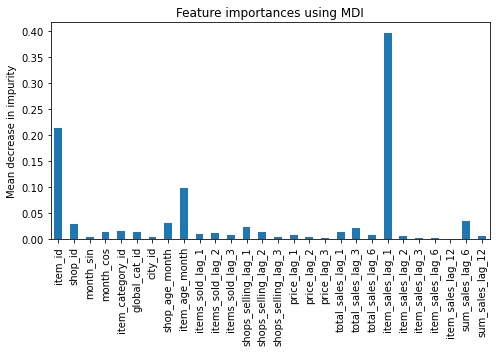

In [35]:
print('RFR before hyperoptimisation')
impurity_decrease_importance(rfr, t_x.columns);

Most important feature is `item_sales_lag_1` - target taken with lag of 1 month.

Other important features are `item_id`, `item_age_month`, `sum_sales_lag_6`.

Except for 4-5 features, everything else seems unmeaningful.

XGBR before hyperoptimisation


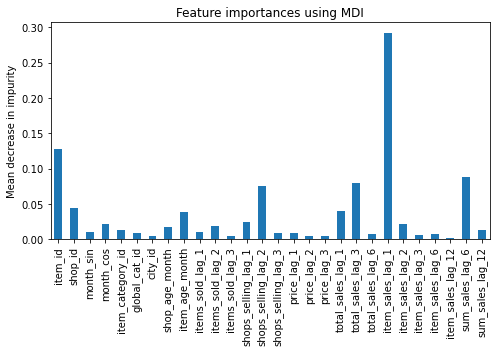

In [36]:
print('XGBR before hyperoptimisation')
impurity_decrease_importance(xgbr, t_x.columns);

Again, the most important feature is `item_sales_lag_1`.

Seems like there are a lot more meaninful features (10 or more).

## Permutations

RFR before hyperoptimisation


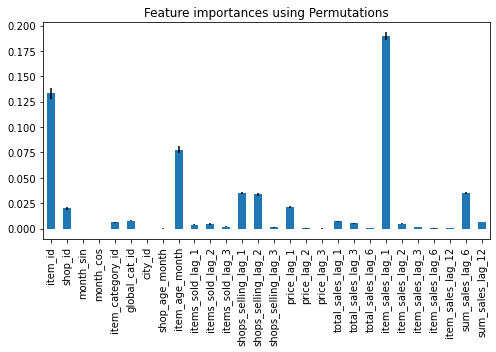

In [38]:
print('RFR before hyperoptimisation')
permute_importance(rfr, v_x, v_y);

XGBR before hyperoptimisation


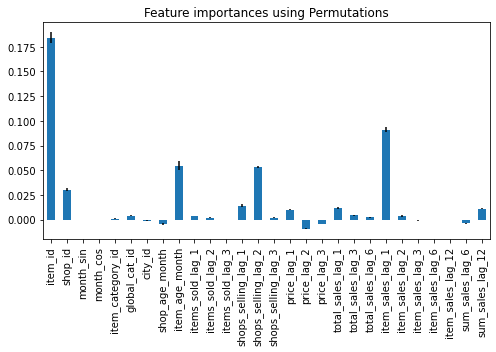

In [39]:
print('XGBR before hyperoptimisation')
permute_importance(xgbr, v_x, v_y);

### Boruta

In [24]:
#!pip install boruta
from boruta import BorutaPy

def boruta_selection(model, X, y, max_iter=30, verbose=0):
    boruta_selector = BorutaPy(model, n_estimators='auto', verbose=verbose, random_state=1001, max_iter=max_iter)
    boruta_selector.fit(X.values, y.ravel()) 
    accept = X.columns[boruta_selector.support_].to_list()
    irresolution = X.columns[boruta_selector.support_weak_].to_list()
    print(f'Accepted features: {accept}')
    print(f'Accepted features (weak): {irresolution}')
    return accept, irresolution

In [66]:
rfr_accept, rfr_irresolution = boruta_selection(rfr, t_x, t_y, max_iter=30, verbose=0)

Accepted features: ['item_id', 'shop_id', 'month_cos', 'item_category_id', 'global_cat_id', 'shop_age_month', 'item_age_month', 'items_sold_lag_1', 'items_sold_lag_2', 'items_sold_lag_3', 'shops_selling_lag_1', 'shops_selling_lag_2', 'price_lag_1', 'total_sales_lag_1', 'total_sales_lag_3', 'total_sales_lag_6', 'item_sales_lag_1', 'item_sales_lag_2', 'sum_sales_lag_6', 'sum_sales_lag_12']
Accepted features (weak): []


In [67]:
xgbr_accept, xgbr_irresolution = boruta_selection(xgbr, t_x, t_y, max_iter=30, verbose=0)

Accepted features: ['item_id', 'shop_id', 'month_sin', 'month_cos', 'item_category_id', 'global_cat_id', 'city_id', 'shop_age_month', 'item_age_month', 'items_sold_lag_1', 'items_sold_lag_2', 'items_sold_lag_3', 'shops_selling_lag_1', 'shops_selling_lag_2', 'shops_selling_lag_3', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'total_sales_lag_1', 'total_sales_lag_3', 'total_sales_lag_6', 'item_sales_lag_1', 'item_sales_lag_2', 'item_sales_lag_3', 'item_sales_lag_6', 'sum_sales_lag_6', 'sum_sales_lag_12']
Accepted features (weak): []


# Hyperparameter tuning 

In [71]:
#!pip install hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [104]:
def hyperparameter_tuning_boosting(params):
    model = XGBRegressor(n_estimators=int(params['n_estimators']), 
                         max_depth=int(params['max_depth']),
                         learning_rate=params['learning_rate'],
                         booster=params['booster'],
                         tree_method=params['tree_method'],
                         gamma=params['gamma'],
                         min_child_weight=int(params['min_child_weight']),
                         subsample=params['subsample'],
                         colsample_bytree=params['colsample_bytree'],
                         colsample_bylevel=params['colsample_bylevel'],
                         colsample_bynode=params['colsample_bynode'],
                         random_state=1001
                        )

    model.fit(t_x, t_y)
    pred = model.predict(v_x)
    mse = mean_squared_error(v_y, pred)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}

#https://xgboost.readthedocs.io/en/stable/python/python_api.html
xgbr_space = {
        'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
        'max_depth': hp.quniform('max_depth', 3, 18, 1),
        'grow_policy': hp.choice('grow_policy',[0,1]),
        'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
        'booster': 'gbtree',
        'tree_method': hp.choice('tree_method',['exact','approx', 'hist']),
        'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
        'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),    
        'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
        'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        'colsample_bylevel': hp.quniform('colsample_bylevel', 0.5, 1, 0.05),
        'colsample_bynode': hp.quniform('colsample_bynode', 0.5, 1, 0.05),
    }

In [106]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning_boosting,
            space=space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials)

print(best)

100%|████████████████████████████████████████████| 50/50 [1:49:35<00:00, 131.51s/trial, best loss: 0.46254295848286026]
{'colsample_bylevel': 0.65, 'colsample_bynode': 0.5, 'colsample_bytree': 0.6000000000000001, 'gamma': 0.9, 'grow_policy': 0, 'learning_rate': 0.025, 'max_depth': 12.0, 'min_child_weight': 2.0, 'n_estimators': 219.0, 'subsample': 0.65, 'tree_method': 0}


In [18]:
xgbr_params = {'n_jobs': -1,
                'random_state': 1001,
                 'n_estimators': 219, 
                 'max_depth': 12,
                 'learning_rate': 0.025,
                 'booster': 'gbtree',
                 'tree_method': 'exact',
                 'gamma': 0.9,
                 'min_child_weight': 2,
                 'subsample': 0.65,
                 'colsample_bytree': 0.6,
                 'colsample_bylevel': 0.65,
                 'colsample_bynode': 0.5}

xgbr_tuned = fit_eval_model(XGBRegressor(**xgbr_params), t_x, t_y, v_x, v_y)

train RMSE - 1.917, val RMSE - 1.738


comparing to *2.2* and *2.0*

In [136]:
def hyperparameter_tuning_forest(params):
    model = RandomForestRegressor(n_jobs=-1, random_state=1001, 
                                  n_estimators=int(params['n_estimators']), 
                                  max_depth=int(params['max_depth']),
                                  min_samples_split=int(params['min_samples_split']),
                                  min_samples_leaf=int(params['min_samples_leaf']),
                                  max_features=params['max_features'],
                                  max_samples=params['max_samples'],
                                 )

    model.fit(t_x, t_y.ravel())
    pred = model.predict(v_x)
    mse = mean_squared_error(v_y, pred)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
rfr_space = {
        'n_estimators': hp.quniform('n_estimators', 10, 1000, 1),
        'max_depth': hp.quniform('max_depth', 3, 20, 1),
        'min_samples_split': hp.quniform('min_samples_split', 2, 100, 1),
        'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 20, 1),
        'max_features': hp.quniform('max_features', 0.1, 0.99, 0.1),
        'max_samples': hp.quniform('max_samples', 0.1, 0.99, 0.1)
    }

In [ ]:
trials = Trials()
best = fmin(fn=hyperparameter_tuning_forest,
            space=rfr_space,
            algo=tpe.suggest,
            max_evals=50,
            trials=trials) 

print(best)

In [19]:
rfr_params = {'n_jobs': -1,
            'random_state': 1001,
             'n_estimators': 399, 
             'max_depth': 18,
             'min_samples_split': 23,
             'min_samples_leaf': 8,
             'max_features': 0.1,
             'max_samples': 0.5}

rfr_tuned = fit_eval_model(RandomForestRegressor(**rfr_params), t_x, t_y, v_x, v_y)

train RMSE - 2.564, val RMSE - 1.833


#### Hyperopt results aren't so good for some reason, maybe I'll add Grid/Random search later or fix hyperopt

In [297]:
rfr_grid = {'max_depth': np.arange(5,21),
             'min_samples_leaf': np.arange(1,20,3),
             'min_samples_split': np.arange(10, 50, 4),
             'n_estimators': [50, 100, 150, 200, 250, 300],
             'max_features': ['auto','sqrt', 1, 0.5, 0.3, 0.7],
             'max_samples':  [0.3, 0.5, 0.7, 1]    
             }

In [146]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rfr_random_search = RandomizedSearchCV(estimator=RandomForestRegressor(random_state=1001), param_distributions = rfr_grid, n_iter = 20, cv = 3, verbose=2, random_state=1001, n_jobs = -1)# Fit the random search model
rfr_random_search.fit(t_x, t_y.ravel())
rfr_random_search.best_params_

In [132]:
rfr_params_random = {'n_jobs': -1,
            'random_state': 1001,
             'n_estimators': 200, 
             'max_depth': 17,
             'min_samples_split': 44,
             'min_samples_leaf': 11,
             'max_features': 0.5,
             'max_samples': 0.7}

rfr_random = fit_eval_model(RandomForestRegressor(**rfr_params_random), t_x, t_y, v_x, v_y)

train RMSE - 2.105, val RMSE - 1.768


looks like this score is better than Hyperopt's

In [ ]:
rfr = RandomForestRegressor(random_state=1001)
rfr_grid_search = GridSearchCV(estimator = rfr, param_grid = rfr_grid, cv = 3, n_jobs = -1, verbose=1)
rfr_grid_search.fit(t_x, t_y.ravel())
rfr_grid_search.best_params_

Fitting 3 folds for each of 161280 candidates, totalling 483840 fits


## Feature importances on tuned models

RFR after hyperoptimisation


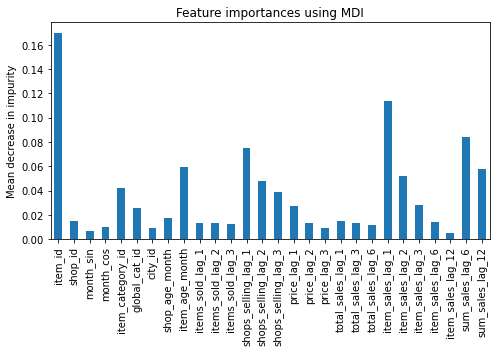

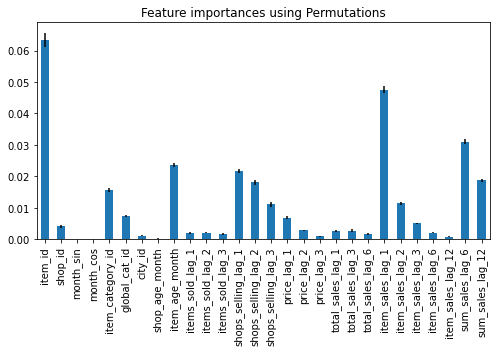

In [20]:
print('RFR after hyperoptimisation')
impurity_decrease_importance(rfr_tuned, t_x.columns);
permute_importance(rfr_tuned, v_x, v_y);

XGBR after hyperoptimisation


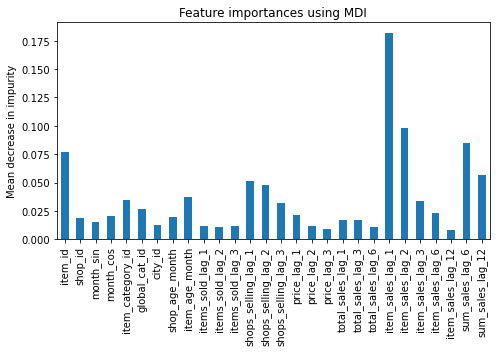

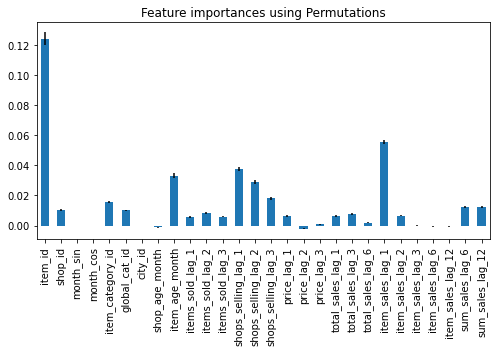

In [41]:
print('XGBR after hyperoptimisation')
impurity_decrease_importance(xgbr_tuned, t_x.columns);
permute_importance(xgbr_tuned, v_x, v_y);

Definetely more features seem meaninful now, but individual importances decreased in both cases.

## Evaluating models on subsets of features

In [22]:
#based on pre-optimisation importances
subset1 = ['item_id', 'shop_id', 'item_age_month', 'shops_selling_lag_2', 'item_sales_lag_1', 'sum_sales_lag_6', 'price_lag_1'] 

#post-optimisation importances from xgbr
subset2 = ['item_id', 'item_sales_lag_1', 'shops_selling_lag_1', 'shops_selling_lag_2', 'shops_selling_lag_3',
           'item_age_month', 'item_category_id']

#post-optimisation importances from rfr
subset3 = ['item_id', 'item_sales_lag_1', 'shops_selling_lag_1', 'item_age_month', 'item_category_id', 
           'sum_sales_lag_6', 'sum_sales_lag_12']

In [23]:
rfr_subset1 = fit_eval_model(RandomForestRegressor(**rfr_params), t_x[subset1], t_y, v_x[subset1], v_y)
xgbr_subset1 = fit_eval_model(XGBRegressor(**xgbr_params), t_x[subset1], t_y, v_x[subset1], v_y)

train RMSE - 2.473, val RMSE - 1.813
train RMSE - 2.458, val RMSE - 1.802


In [24]:
rfr_subset2 = fit_eval_model(RandomForestRegressor(**rfr_params), t_x[subset2], t_y, v_x[subset2], v_y)
xgbr_subset2 = fit_eval_model(XGBRegressor(**xgbr_params), t_x[subset2], t_y, v_x[subset2], v_y)

train RMSE - 2.468, val RMSE - 1.916
train RMSE - 2.552, val RMSE - 1.826


In [25]:
rfr_subset3 = fit_eval_model(RandomForestRegressor(**rfr_params), t_x[subset3], t_y, v_x[subset3], v_y)
xgbr_subset3 = fit_eval_model(XGBRegressor(**xgbr_params), t_x[subset3], t_y, v_x[subset3], v_y)

train RMSE - 2.453, val RMSE - 1.795
train RMSE - 2.488, val RMSE - 1.814


Seems to induce overfitting in XGBR, RMSE didn't change dramatically for any of the subsets.

## Explainability with SHAP

In [20]:
#!pip install shap 
import shap
shap.initjs();
t_x_sample = t_x.sample(n=1000, random_state=1001) #for faster computation

### XGBR

In [21]:
xgbr_explainer = shap.TreeExplainer(xgbr_tuned)

In [22]:
xgbr_shap_values = xgbr_explainer.shap_values(t_x_sample)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


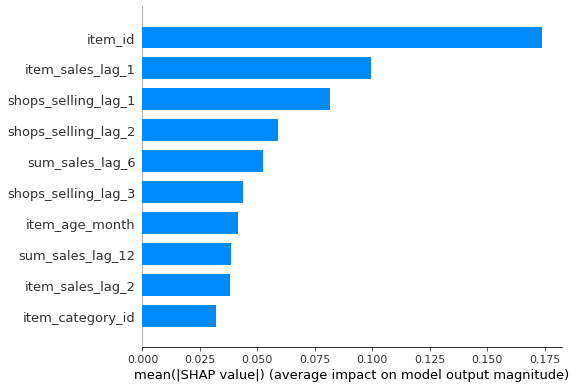

In [23]:
shap.summary_plot(xgbr_shap_values, t_x_sample, feature_names=t_x.columns, plot_type="bar", max_display=10)

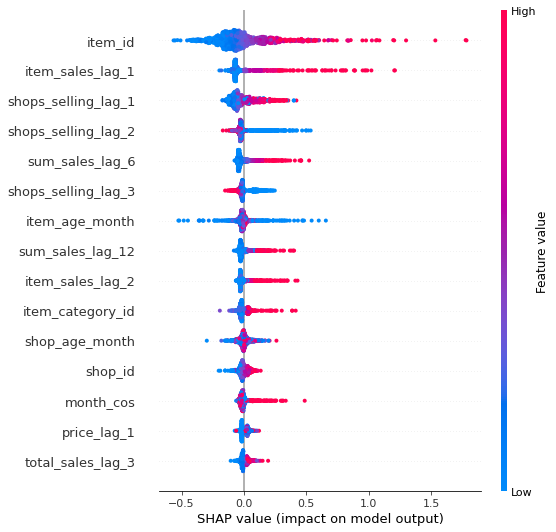

In [168]:
shap.summary_plot(xgbr_shap_values, t_x_sample, feature_names=t_x.columns, max_display=15)

We see top 20 features with biggest SHAP values, which could be useful for feature importance.

Let's see some dependency plots:

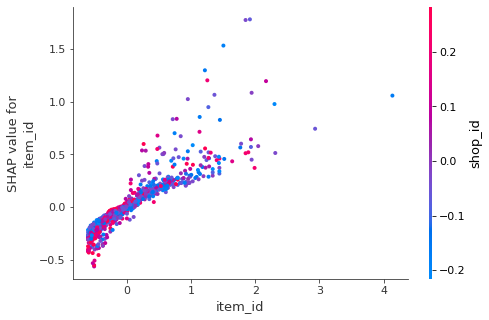

In [22]:
shap.dependence_plot(0, xgbr_shap_values, t_x_sample, feature_names=t_x.columns, interaction_index='shop_id')

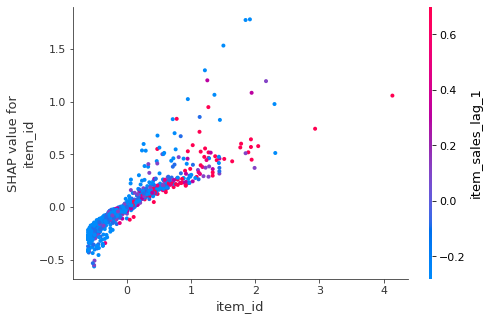

In [23]:
shap.dependence_plot(0, xgbr_shap_values, t_x_sample, feature_names=t_x.columns, interaction_index='item_sales_lag_1')

For example, samples with lower price last month tend to have bigger SHAP-values for `item_id`

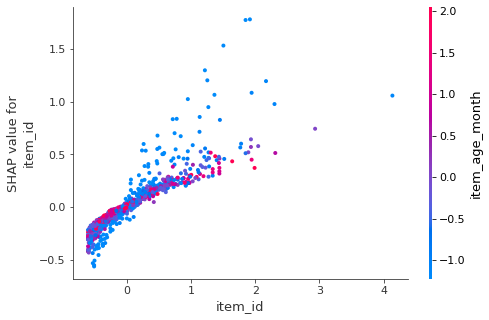

In [24]:
shap.dependence_plot(0, xgbr_shap_values, t_x_sample, feature_names=t_x.columns, interaction_index='item_age_month')

In [24]:
shap.force_plot(xgbr_explainer.expected_value, xgbr_shap_values[18], t_x_sample.values[18], feature_names = t_x.columns)

It's hard to judge since target variable has been transformed so much, but we can definetely see impact of `item_id` and `item_sales_lag_1`.

### RFR and SHAP

In [25]:
t_x_sample = t_x.sample(n=100, random_state=1001)

In [26]:
rfr_explainer  = shap.Explainer(rfr_tuned, t_x_sample)
shap_values = rfr_explainer(t_x_sample)

 98%|===================| 98/100 [00:56<00:01]        

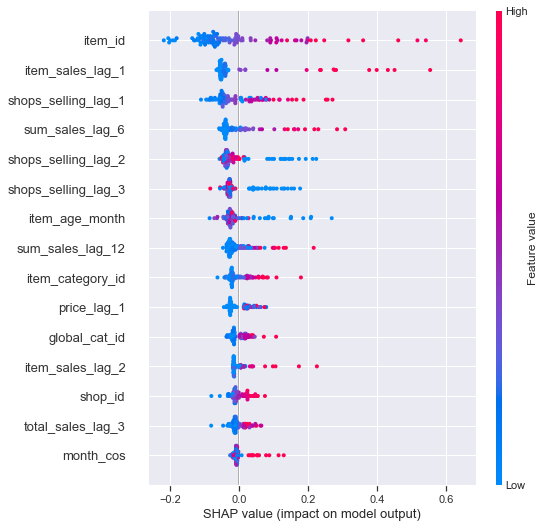

In [265]:
shap.summary_plot(shap_values.values, shap_values.data, shap_values.feature_names, max_display=15)

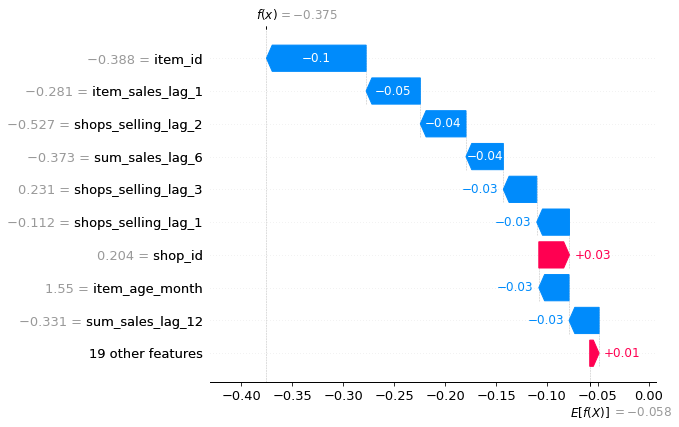

In [113]:
shap.plots.waterfall(shap_values[0])

## Error analysis

In [39]:
import seaborn as sns

In [28]:
val_pred = xgbr_tuned.predict(v_x)
val_pred = target_trasformer.inverse_transform(val_pred)
val_error_analysis = val.copy()
val_error_analysis['pred'] = val_pred
val_error_analysis.rename(columns={'item_cnt_month': 'target'}, inplace=True)
val_error_analysis['error'] = np.abs(val_error_analysis['target'] - val_error_analysis['pred'])
val_error_analysis['error_unsigned'] = val_error_analysis['target'] - val_error_analysis['pred']

In [56]:
val_error_analysis[['target', 'pred', 'error']].head(5)

,target,pred,error
23502,57.0,2.771162,54.228838
32769,70.0,16.980284,53.019716
1793,52.0,1.670986,50.329014
11141,49.0,2.161894,46.838106
18132,48.0,1.164456,46.835544


In [28]:
val_error_analysis[['target', 'pred', 'error']].describe()

,target,pred,error
count,32765.000000,32765.000000,32765.000000
mean,1.799268,1.749303,0.735425
std,2.597617,1.729932,1.566837
min,1.000000,0.933798,0.000039
25%,1.000000,1.172052,0.168796
50%,1.000000,1.352129,0.360528
75%,2.000000,1.759231,0.762449
max,73.000000,55.891521,54.228838


Assumption is that a small percentage of samples is responsible for a major part of error.

Let's separate top 1% rows with bigger error from the rest.

In [29]:
val_error_analysis.sort_values(['error'], ascending=False, inplace=True)

In [30]:
top_1percent_errors = val_error_analysis[:int(val_error_analysis.shape[0]/100)].copy()
top_errors_ind = top_1percent_errors.index
rest_99percent_errors = val_error_analysis[int(val_error_analysis.shape[0]/100):].copy()

In [31]:
print(f'RMSE total : {mean_squared_error(val_error_analysis.target, val_error_analysis.pred, squared=False)}')
print(f'RMSE on top 1% : {mean_squared_error(top_1percent_errors.target, top_1percent_errors.pred, squared=False)}')
print(f'RMSE on other 99% : {mean_squared_error(rest_99percent_errors.target, rest_99percent_errors.pred, squared=False)}')

RMSE total : 1.737571512207578
RMSE on top 1% : 14.1986176259221
RMSE on other 99% : 1.0086126875997443


We see that only 1% of cases accounts for almost half of RMSE.

How are these cases different? 

#### Bigger targets

In [75]:
bins = [0, 1, 2, 10, 50, 100]
val_error_analysis['target_binned'] = pd.cut(val_error_analysis['target'], bins=bins)
val_error_analysis.groupby(['target_binned']).agg({'error': ['mean','min', 'max']})

error                     
                    mean       min        max
target_binned                                
(0, 1]          0.401901  0.000310   9.571997
(1, 2]          0.612661  0.000039   8.712447
(2, 10]         1.888247  0.001957  15.474775
(10, 50]        9.139316  0.035322  46.838106
(50, 100]      27.409328  5.121689  54.228838

We can see from the table that errors after `target > 10` increase drastically.

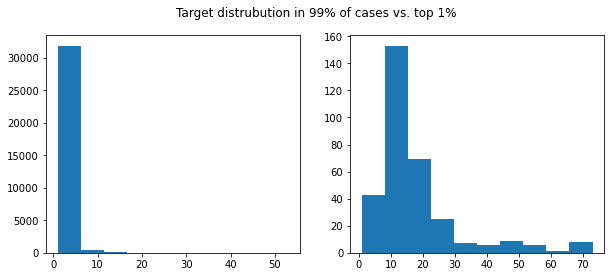

In [80]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(10, 4)
axes[0].hist(rest_99percent_errors['target']);
axes[1].hist(top_1percent_errors['target']);
fig.suptitle('Target distrubution in 99% of cases vs. top 1%');

#### Shop and item dynamics

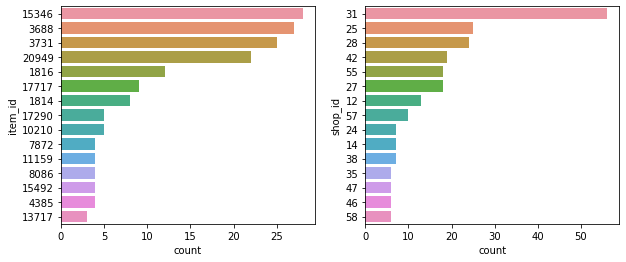

In [81]:
fig, axes = plt.subplots(ncols=2, nrows=1)
fig.set_size_inches(10, 4)
for ax, col in zip(axes.flatten(), ['item_id', 'shop_id']):
    sns.countplot(data=top_1percent_errors, y=col, ax=ax, order=top_1percent_errors[col].value_counts().iloc[:15].index)

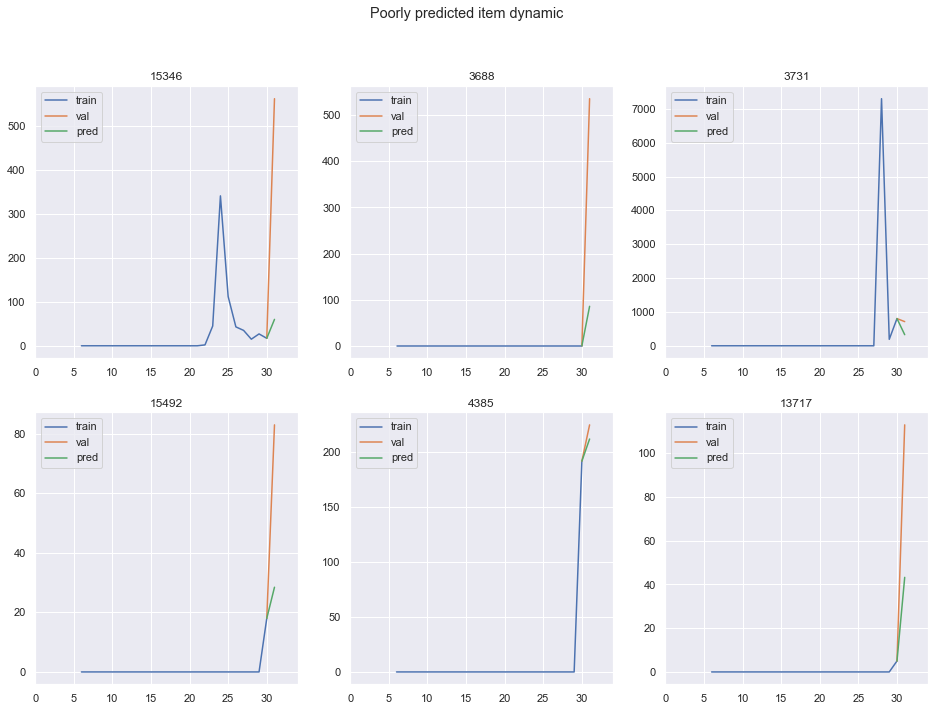

In [185]:
sns.set(rc={'figure.figsize':(16,11)})
fig, axs = plt.subplots(ncols=3, nrows=2)
problematic_items = [15346, 3688, 3731, 15492, 4385, 13717]

train_start = 5
val_start = 30

for item_id, ax in zip(problematic_items, axs.flatten()):
    item_dyn = monthly_sales_pivot[monthly_sales_pivot['item_id']==item_id].sum(axis=0).values[2+train_start:2+val_start]
    val_item_dyn = [item_dyn[-1], monthly_sales_pivot[monthly_sales_pivot['item_id']==item_id].sum(axis=0).values[2+val_start]]
    pred_item_dyn = [item_dyn[-1], val_error_analysis[val_error_analysis['item_id']==item_id]['pred'].sum()]
    sns.lineplot(x=range(train_start+1,val_start+1), y=item_dyn, label='train', ax=ax)
    sns.lineplot(x=[val_start,val_start+1], y=val_item_dyn, label='val', ax=ax)
    sns.lineplot(x=[val_start,val_start+1], y=pred_item_dyn, label='pred', ax=ax)
    ax.set_title(item_id)
    ax.set_xlim([0,34])
fig.suptitle('Poorly predicted item dynamic');

We can see that the model makes big errors on items that rapidly became popular and have sudden jumps in their dynamics.

### Individual predictions with weird dynamics

In [32]:
item_3688_errors = top_1percent_errors[top_1percent_errors['item_id']==3688].index
item_15492_errors = top_1percent_errors[top_1percent_errors['item_id']==15492].index

In [33]:
top_errors_x = v_x.loc[item_3688_errors]
error_shap_values = xgbr_explainer.shap_values(top_errors_x)
shap.force_plot(xgbr_explainer.expected_value, error_shap_values[0], top_errors_x.values[0], feature_names = top_errors_x.columns)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [34]:
top_errors_x = v_x.loc[item_15492_errors]
error_shap_values = xgbr_explainer.shap_values(top_errors_x)
shap.force_plot(xgbr_explainer.expected_value, error_shap_values[0], top_errors_x.values[0], feature_names = top_errors_x.columns)

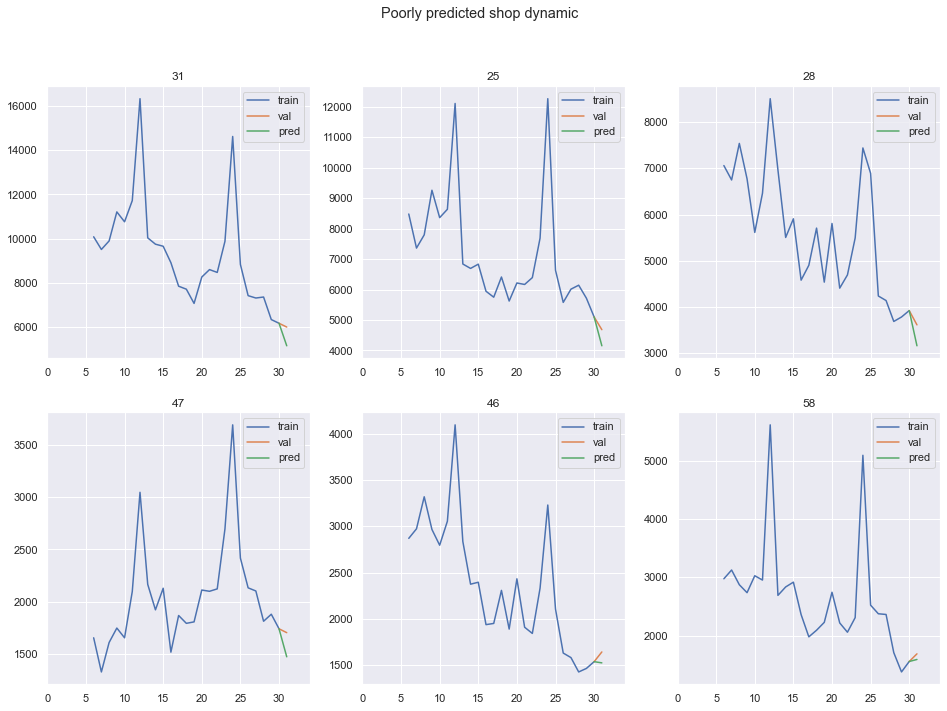

In [183]:
sns.set(rc={'figure.figsize':(16,11)})
fig, axs = plt.subplots(ncols=3, nrows=2)
problematic_shops = [31, 25, 28, 47, 46, 58]

train_start = 5
val_start = 30

for shop_id, ax in zip(problematic_shops, axs.flatten()):
    item_dyn = monthly_sales_pivot[monthly_sales_pivot['shop_id']==shop_id].sum(axis=0).values[2+train_start:2+val_start]
    val_item_dyn = [item_dyn[-1], monthly_sales_pivot[monthly_sales_pivot['shop_id']==shop_id].sum(axis=0).values[2+val_start]]
    pred_item_dyn = [item_dyn[-1], val_error_analysis[val_error_analysis['shop_id']==shop_id]['pred'].sum()]
    sns.lineplot(x=range(train_start+1,val_start+1), y=item_dyn, label='train', ax=ax)
    sns.lineplot(x=[val_start,val_start+1], y=val_item_dyn, label='val', ax=ax)
    sns.lineplot(x=[val_start,val_start+1], y=pred_item_dyn, label='pred', ax=ax)
    ax.set_title(shop_id)
    ax.set_xlim([0,34])
fig.suptitle('Poorly predicted shop dynamic');

Shop dynamics are more or less stable, but model tends to underestimate their sales.

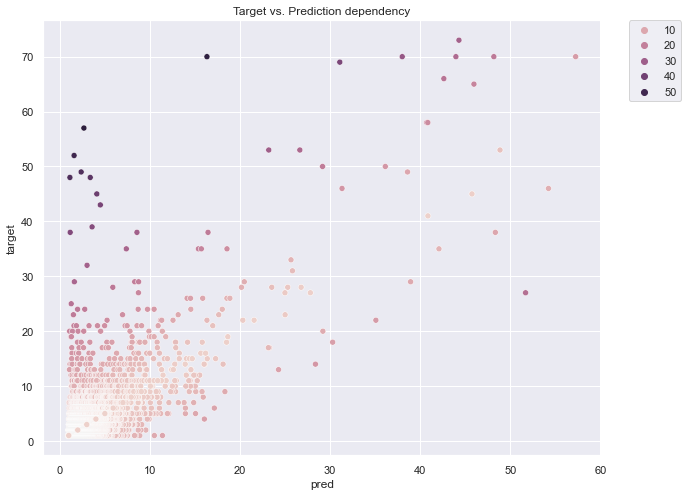

In [218]:
sns.set(rc={'figure.figsize':(10,8)})
sns.scatterplot(data=val_error_analysis, x='pred', y='target',hue='error')
plt.title('Target vs. Prediction dependency')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [35]:
neg_errors = val_error_analysis[val_error_analysis['error_unsigned'] < 0]
pos_errors = val_error_analysis[val_error_analysis['error_unsigned'] >= 0]

pos_error_vis = pos_errors.groupby(['target']).agg({'error_unsigned': 'median'}).reset_index().rename(columns={'error_unsigned': 'median_pos_error'})
neg_error_vis = neg_errors.groupby(['target']).agg({'error_unsigned': 'median'}).reset_index().rename(columns={'error_unsigned': 'median_neg_error'})

error_vis = pos_error_vis.merge(neg_error_vis, on='target',how='left')
error_vis.fillna(0, inplace=True)

In [41]:
upper = error_vis['median_pos_error'].rolling(5).median()
upper.fillna(error_vis.loc[upper.isna().index,'median_pos_error'], inplace=True)

lower = error_vis['median_neg_error'].rolling(5).median()
lower.fillna(error_vis.loc[lower.isna().index,'median_neg_error'], inplace=True)

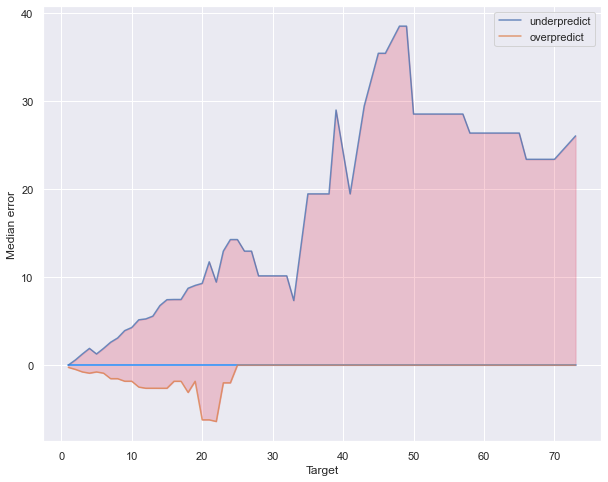

In [42]:
sns.set(rc={'figure.figsize':(10,8)})
plt.plot(error_vis['target'], np.zeros(error_vis.shape[0]), color='dodgerblue')
plt.plot(error_vis['target'], upper, alpha=0.8, label='underpredict')
plt.plot(error_vis['target'], lower, alpha=0.8, label='overpredict')
plt.fill_between(error_vis['target'], upper, lower, color='crimson', alpha=0.2)
plt.xlabel('Target')
plt.ylabel('Median error')
plt.legend()

plt.show()

## Submission 

In [135]:
from datetime import date

class MonthlySalesTest(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None ):
        return self
    def transform(self, X, y=None):
        X['date_block_num'] = 34
        X['date'] = date(2015, 34 % 12 + 1, 28)
        X['date'] = pd.to_datetime(X['date'], format="%Y-%m-%d")
        
        return X

extraction_steps_test = [("montly_sales", MonthlySalesTest()),
                ("month_feat", MonthFromDate()),
                ("merge", MergeTables(datasets)),
                ("ages", ShopItemAge())
            ]

feature_extraction_pipeline_test = Pipeline(steps=extraction_steps_test)

In [136]:
test = pd.read_csv('../data/interim/test_etl.csv', index_col='ID')
test_x = feature_extraction_pipeline_test.fit_transform(test)

test_x = lag_pipeline.transform(test_x)

test_x = preprocessing_pipeline.transform(test_x)


test_x.head()

,shop_id,item_id,month_sin,month_cos,item_category_id,global_cat_id,city_id,shop_age_month,item_age_month,items_sold_lag_1,...,total_sales_lag_1,total_sales_lag_3,total_sales_lag_6,item_sales_lag_1,item_sales_lag_2,item_sales_lag_3,item_sales_lag_6,item_sales_lag_12,sum_sales_lag_6,sum_sales_lag_12
0,-0.142712,5.722512e-01,-0.5,0.866025,2.360894e-01,2.039111e-01,-0.142712,2.444788,0.731140,-0.954151,...,-0.886358,-0.799842,-0.841017,-0.280524,-0.064300,0.379438,0.000668,0.126611,-0.011615,0.018621
1,-0.142712,-9.895837e-14,-0.5,0.866025,-9.895837e-14,-9.895837e-14,-0.142712,2.444788,-1.295928,-0.954151,...,-0.886358,-0.799842,-0.841017,-0.280524,-0.266942,-0.264025,-0.219094,-0.151131,-0.373110,-0.362671
2,-0.142712,5.156869e-01,-0.5,0.866025,2.360894e-01,2.039111e-01,-0.142712,2.444788,-0.248076,-0.954151,...,-0.886358,-0.799842,-0.841017,-0.084743,0.340983,-0.049538,0.440192,-0.151131,0.143311,-0.044928
3,-0.142712,-9.895837e-14,-0.5,0.866025,1.985326e-01,2.039111e-01,-0.142712,2.444788,-0.792593,-0.954151,...,-0.886358,-0.799842,-0.841017,-0.280524,-0.266942,-0.049538,-0.219094,-0.151131,-0.321468,-0.330897
4,-0.142712,-9.895837e-14,-0.5,0.866025,-9.895837e-14,-9.895837e-14,-0.142712,2.444788,-1.295928,-0.954151,...,-0.886358,-0.799842,-0.841017,-0.280524,-0.266942,-0.264025,-0.219094,-0.151131,-0.373110,-0.362671


In [137]:
#rfr_pred = target_trasformer.inverse_transform(rfr_tuned.predict(test_x))
#xgbr_pred = target_trasformer.inverse_transform(xgbr_tuned.predict(test_x))
#rfr_usual_pred = target_trasformer.inverse_transform(rfr.predict(test_x))
rfr_random_pred = target_trasformer.inverse_transform(rfr_random.predict(test_x))

In [138]:
submission = pd.DataFrame(rfr_random_pred, columns=['item_cnt_month']).reset_index()
submission.to_csv('../data/processed/sub_exp6.csv', header=['ID', 'item_cnt_month'], index=False)
submission

,index,item_cnt_month
0,0,1.472501
1,1,1.069987
2,2,1.536232
3,3,1.216815
4,4,1.069987
...,...,...
214195,214195,1.245119
214196,214196,1.159238
214197,214197,1.131612
214198,214198,1.099769


Hypertuned RFR produced best score on Kaggle so far - 1.439

## Ideas for further experiments:

* try tuning RFR even more
* exploring feature selection, dropping low-informative features from pipelines 
* working aroud poor item dynamics: either finding a way to detect and drop such samples or find a way to encode it into feature (for example, day of the first sell - it may be helpful for items that appeared on the market a long time ago but were unsuccessful and only recently started actuaaly getting sold)
* experimenting with training data size and location on the timeline, trying to reduce the size without loosing accuracy
* try rising the threshold in outliar remover function
* oversample bigger target

In [123]:
t_x_short = t_x.drop(columns=['month_cos', 'month_sin','city_id', 'global_cat_id'], axis=1)
v_x_short = v_x.drop(columns=['month_cos', 'month_sin','city_id', 'global_cat_id'], axis=1)

In [124]:
rfr_subset = fit_eval_model(RandomForestRegressor(**rfr_params), t_x_short, t_y, v_x_short, v_y)
xgbr_subset = fit_eval_model(XGBRegressor(**xgbr_params), t_x_short, t_y, v_x_short, v_y)

train RMSE - 2.547, val RMSE - 1.816
train RMSE - 2.003, val RMSE - 1.764


however, did not improve Kaggle score